# Importing Libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

# Fetching Dataset

In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip

--2022-01-22 10:31:13--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.41.96
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.41.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3745528792 (3.5G) [application/octet-stream]
Saving to: ‘9xkhgts2s6-1.zip’

9xkhgts2s6-1.zip    100%[===================>]   3.49G  21.5MB/s    in 2m 47s  

2022-01-22 10:34:01 (21.4 MB/s) - ‘9xkhgts2s6-1.zip’ saved [3745528792/3745528792]



# Unzipping Dataset

In [3]:
%%capture
!unzip 9xkhgts2s6-1.zip

# Setting Directories and Hyperparameters

In [4]:
image_directory='Curated X-Ray Dataset/Curated X-Ray Dataset/'

no_covid_images=os.listdir(image_directory+ 'Normal/')
yes_covid_images=os.listdir(image_directory+ 'COVID-19/')
pneumonia_viral_images=os.listdir(image_directory+ 'Pneumonia-Viral/')

dataset=[]
label=[]

INPUT_SIZE=128

# Processing Dataset

In [5]:
for i , image_name in tqdm(enumerate(no_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Normal/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in tqdm(enumerate(yes_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'COVID-19/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

for i , image_name in tqdm(enumerate(pneumonia_viral_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Pneumonia-Viral/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(2)

3270it [01:51, 29.35it/s]
1281it [00:51, 24.93it/s]
1656it [00:36, 45.50it/s]


In [6]:
dataset=np.array(dataset)
label=np.array(label)

# Splitting Training and Validation Data

In [7]:
x_train, x_split, y_train, y_split = train_test_split(dataset, label, test_size=0.2, random_state=0)

x_train=tf.keras.utils.normalize(x_train, axis=1)
y_train=tf.keras.utils.to_categorical(y_train , num_classes=3)

# Splitting Validation and Testing Data

In [8]:
x_val, x_test, y_val, y_test = train_test_split(x_split, y_split, test_size=0.5, random_state=0)

x_val = tf.keras.utils.normalize(x_val, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

y_val = tf.keras.utils.to_categorical(y_val , num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=3)

# Setting Base Model

In [9]:
base_model = Xception(input_shape=(128, 128, 3), weights='imagenet', include_top=False, pooling='max')

for layer in base_model.layers:
    layer.trainable = False

2022-01-22 10:38:22.232408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 10:38:22.370031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 10:38:22.370812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 10:38:22.373139: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 1s 0us/step


# Building Model Architecture

In [10]:
input = base_model.input

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(3, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# Plotting Function

In [11]:
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()

# Model Summary

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Compiling Model

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Training

In [14]:
%%time
history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    verbose=1, epochs=1000, 
    validation_data=(x_val, y_val)
    )

2022-01-22 10:38:38.543206: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.
2022-01-22 10:38:39.823393: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.
2022-01-22 10:38:40.915909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2022-01-22 10:38:43.906780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


156/156 [==============================] - 14s 42ms/step - loss: 0.4803 - accuracy: 0.8467 - val_loss: 0.2484 - val_accuracy: 0.9179
Epoch 2/1000
156/156 [==============================] - 5s 34ms/step - loss: 0.2731 - accuracy: 0.9013 - val_loss: 0.2388 - val_accuracy: 0.9227
Epoch 3/1000
156/156 [==============================] - 5s 34ms/step - loss: 0.2346 - accuracy: 0.9144 - val_loss: 0.2018 - val_accuracy: 0.9243
Epoch 4/1000
156/156 [==============================] - 5s 34ms/step - loss: 0.2137 - accuracy: 0.9210 - val_loss: 0.2356 - val_accuracy: 0.9291
Epoch 5/1000
156/156 [==============================] - 5s 35ms/step - loss: 0.1888 - accuracy: 0.9329 - val_loss: 0.1819 - val_accuracy: 0.9372
Epoch 6/1000
156/156 [==============================] - 5s 33ms/step - loss: 0.1820 - accuracy: 0.9313 - val_loss: 0.1760 - val_accuracy: 0.9388
Epoch 7/1000
156/156 [==============================] - 5s 34ms/step - loss: 0.1701 - accuracy: 0.9386 - val_loss: 0.1871 - val_accuracy: 0.93

# Saving Model

In [15]:
model.save(os.path.join("models", "model.final.h5"))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Evaluating Model

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

20/20 [==============================] - 1s 30ms/step - loss: 2.6074 - accuracy: 0.9340
Test loss:  2.6074435710906982
Accuracy:  0.933977484703064


# Saving History

In [17]:
history.history

{'loss': [0.4803268015384674,
  0.27313974499702454,
  0.23457245528697968,
  0.21374599635601044,
  0.1888047456741333,
  0.18203046917915344,
  0.17010332643985748,
  0.1650199443101883,
  0.16108901798725128,
  0.14911507070064545,
  0.1267780065536499,
  0.12754149734973907,
  0.12422629445791245,
  0.10498693585395813,
  0.11740285903215408,
  0.11025133728981018,
  0.11450868099927902,
  0.0948476493358612,
  0.09281398355960846,
  0.08648233860731125,
  0.08239662647247314,
  0.08490557223558426,
  0.08710645884275436,
  0.07872398942708969,
  0.07719288021326065,
  0.0674237608909607,
  0.06570101529359818,
  0.07154452800750732,
  0.05931193754076958,
  0.06654055416584015,
  0.07100439071655273,
  0.07953304052352905,
  0.07369571924209595,
  0.06256216764450073,
  0.04991457611322403,
  0.04991742968559265,
  0.0619833841919899,
  0.07673072069883347,
  0.06401022523641586,
  0.05623812973499298,
  0.054895106703042984,
  0.043735891580581665,
  0.039636384695768356,
  0.042

# Plotting Curves

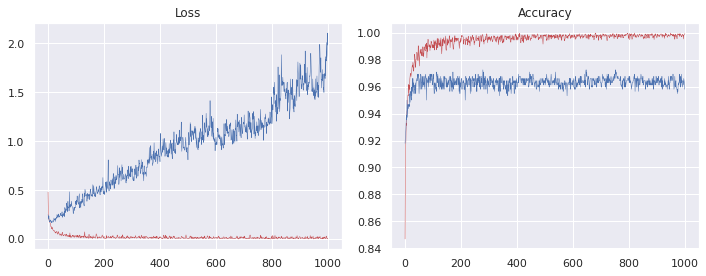

In [18]:
plot(history.history)

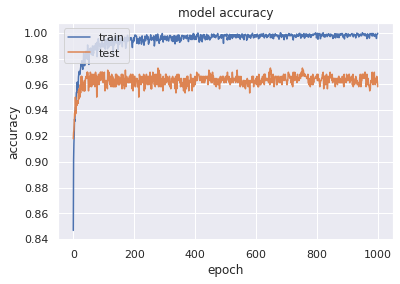

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

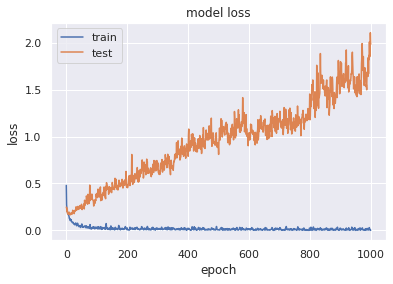

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
%%time
model.predict(x_train)

2022-01-22 12:14:16.302209: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.
2022-01-22 12:14:17.329573: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.


CPU times: user 5.52 s, sys: 2 s, total: 7.52 s
Wall time: 7.29 s


array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.7133076e-27, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.4944505e-33, 7.1678193e-36],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [22]:
%%time
y_pred = model.predict(x_test)

CPU times: user 666 ms, sys: 183 ms, total: 850 ms
Wall time: 911 ms


In [23]:
Y_pred = np.argmax(y_pred, axis=1)

In [24]:
Y_test = np.argmax(y_test, axis=1)

In [25]:
Y_test  

array([0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0,
       2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1,
       0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       2, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0,
       2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0,
       0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0,

In [26]:
Y_pred

array([0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       2, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0,
       2, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0,
       0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0,

In [27]:
%%time
result = model.predict(x_test[[0]])

CPU times: user 132 ms, sys: 496 µs, total: 133 ms
Wall time: 144 ms


In [28]:
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[317   2  11]
 [  3 116   4]
 [ 18   3 147]]
Accuracy :  0.6972624798711755
Sensitivity :  0.9937304075235109
Specificity :  0.9747899159663865


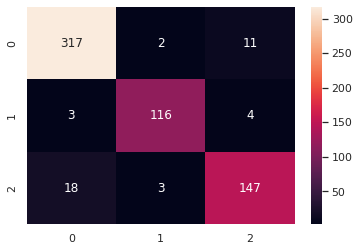

In [29]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

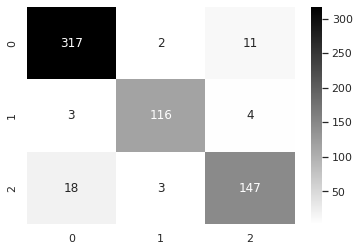

In [30]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="binary",annot=True,fmt="d")

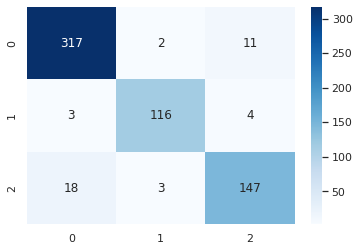

In [31]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="Blues", annot=True,fmt="d")

In [32]:
print(classification_report(Y_test, Y_pred, target_names = ['NORMAL', 'COVID', 'Pneumonia']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.96      0.95       330
       COVID       0.96      0.94      0.95       123
   Pneumonia       0.91      0.88      0.89       168

    accuracy                           0.93       621
   macro avg       0.93      0.93      0.93       621
weighted avg       0.93      0.93      0.93       621



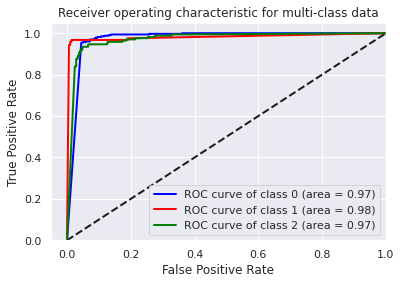

In [33]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [34]:
def display_training_curves(history, name, model_name, EPOCHS =1000):
    '''
    Plots the training process
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,15))
    fig.suptitle(model_name, size=20)
    
    # plot AUC
    ax1.plot(np.arange(EPOCHS),history.history['accuracy'],'-o',
             label='train',color='#ff7f0e')
    ax1.plot(np.arange(EPOCHS),history.history['val_accuracy'],'-o',
             label='val',color='#1f77b4')
    x = np.argmax(history.history['val_accuracy']); y = np.max(history.history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    ax1.scatter(x,y,s=200,color='#1f77b4')
    ax1.text(x-0.03*xdist,y-0.05*ydist,'max accuracy\n%.2f'%y,size=14)
    ax1.set_ylabel('Accuracy',size=14); ax1.set_xlabel('Epoch',size=14)
    ax1.set_title('Accuracy')
    ax1.set_xticks(list(range(EPOCHS)))
    ax1.set_xticklabels(list(range(1, EPOCHS+1)))
    ax1.legend(loc=2)

    #  plot loss
    ax2.plot(np.arange(EPOCHS),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    ax2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin(history.history['val_loss'] )
    y = np.min(history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    ax2.scatter(x,y,s=200,color='#d62728')
    ax2.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    ax2.set_ylabel('Loss',size=14); ax2.set_xlabel('Epoch',size=14)
    ax2.set_title('Loss')
    ax2.set_xticks(list(range(EPOCHS)))
    ax2.set_xticklabels(list(range(1, EPOCHS+1)))
    ax2.legend(loc=3)
    plt.savefig(name + '.png')
    plt.show() 

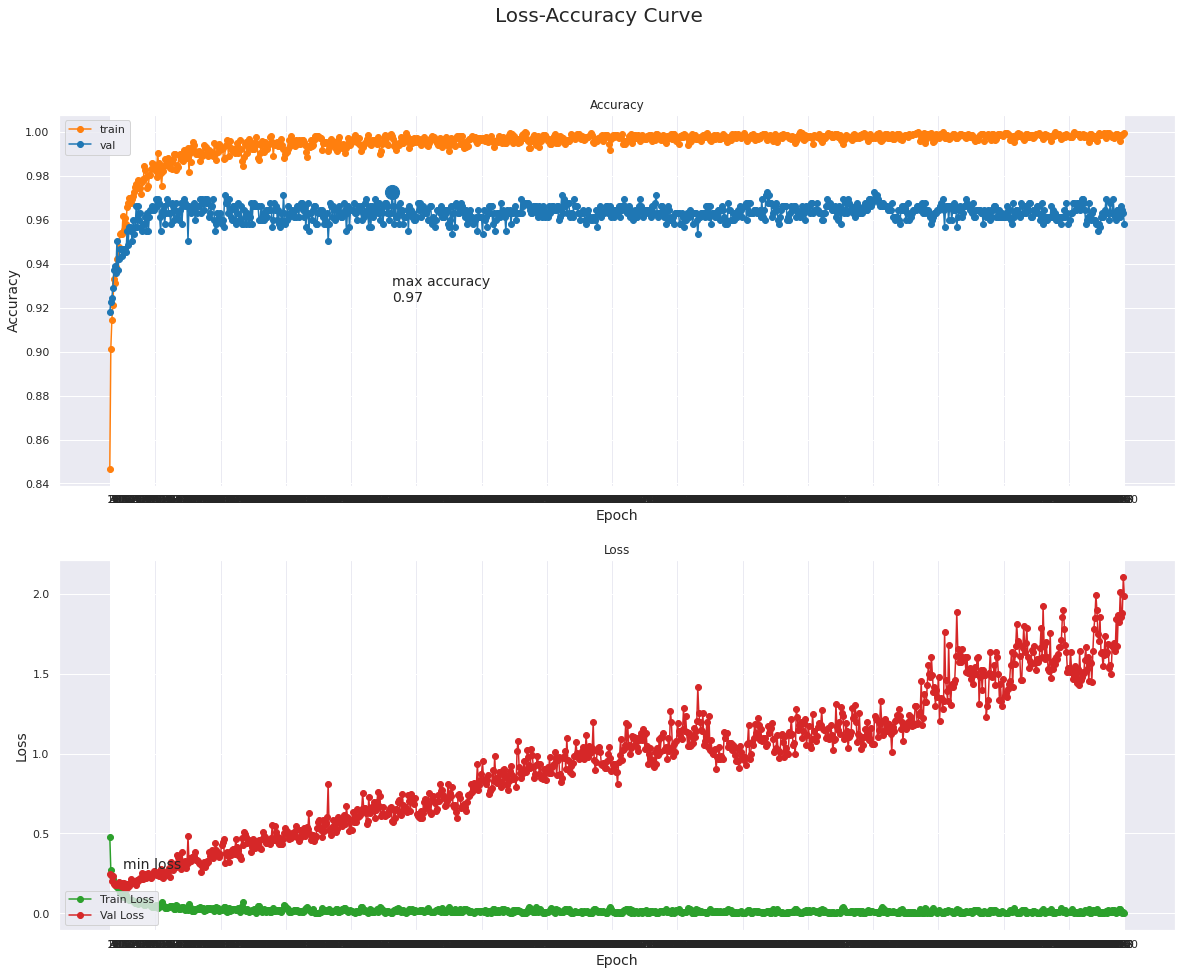

In [35]:
display_training_curves(history, 'name', 'Loss-Accuracy Curve')